In [1]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

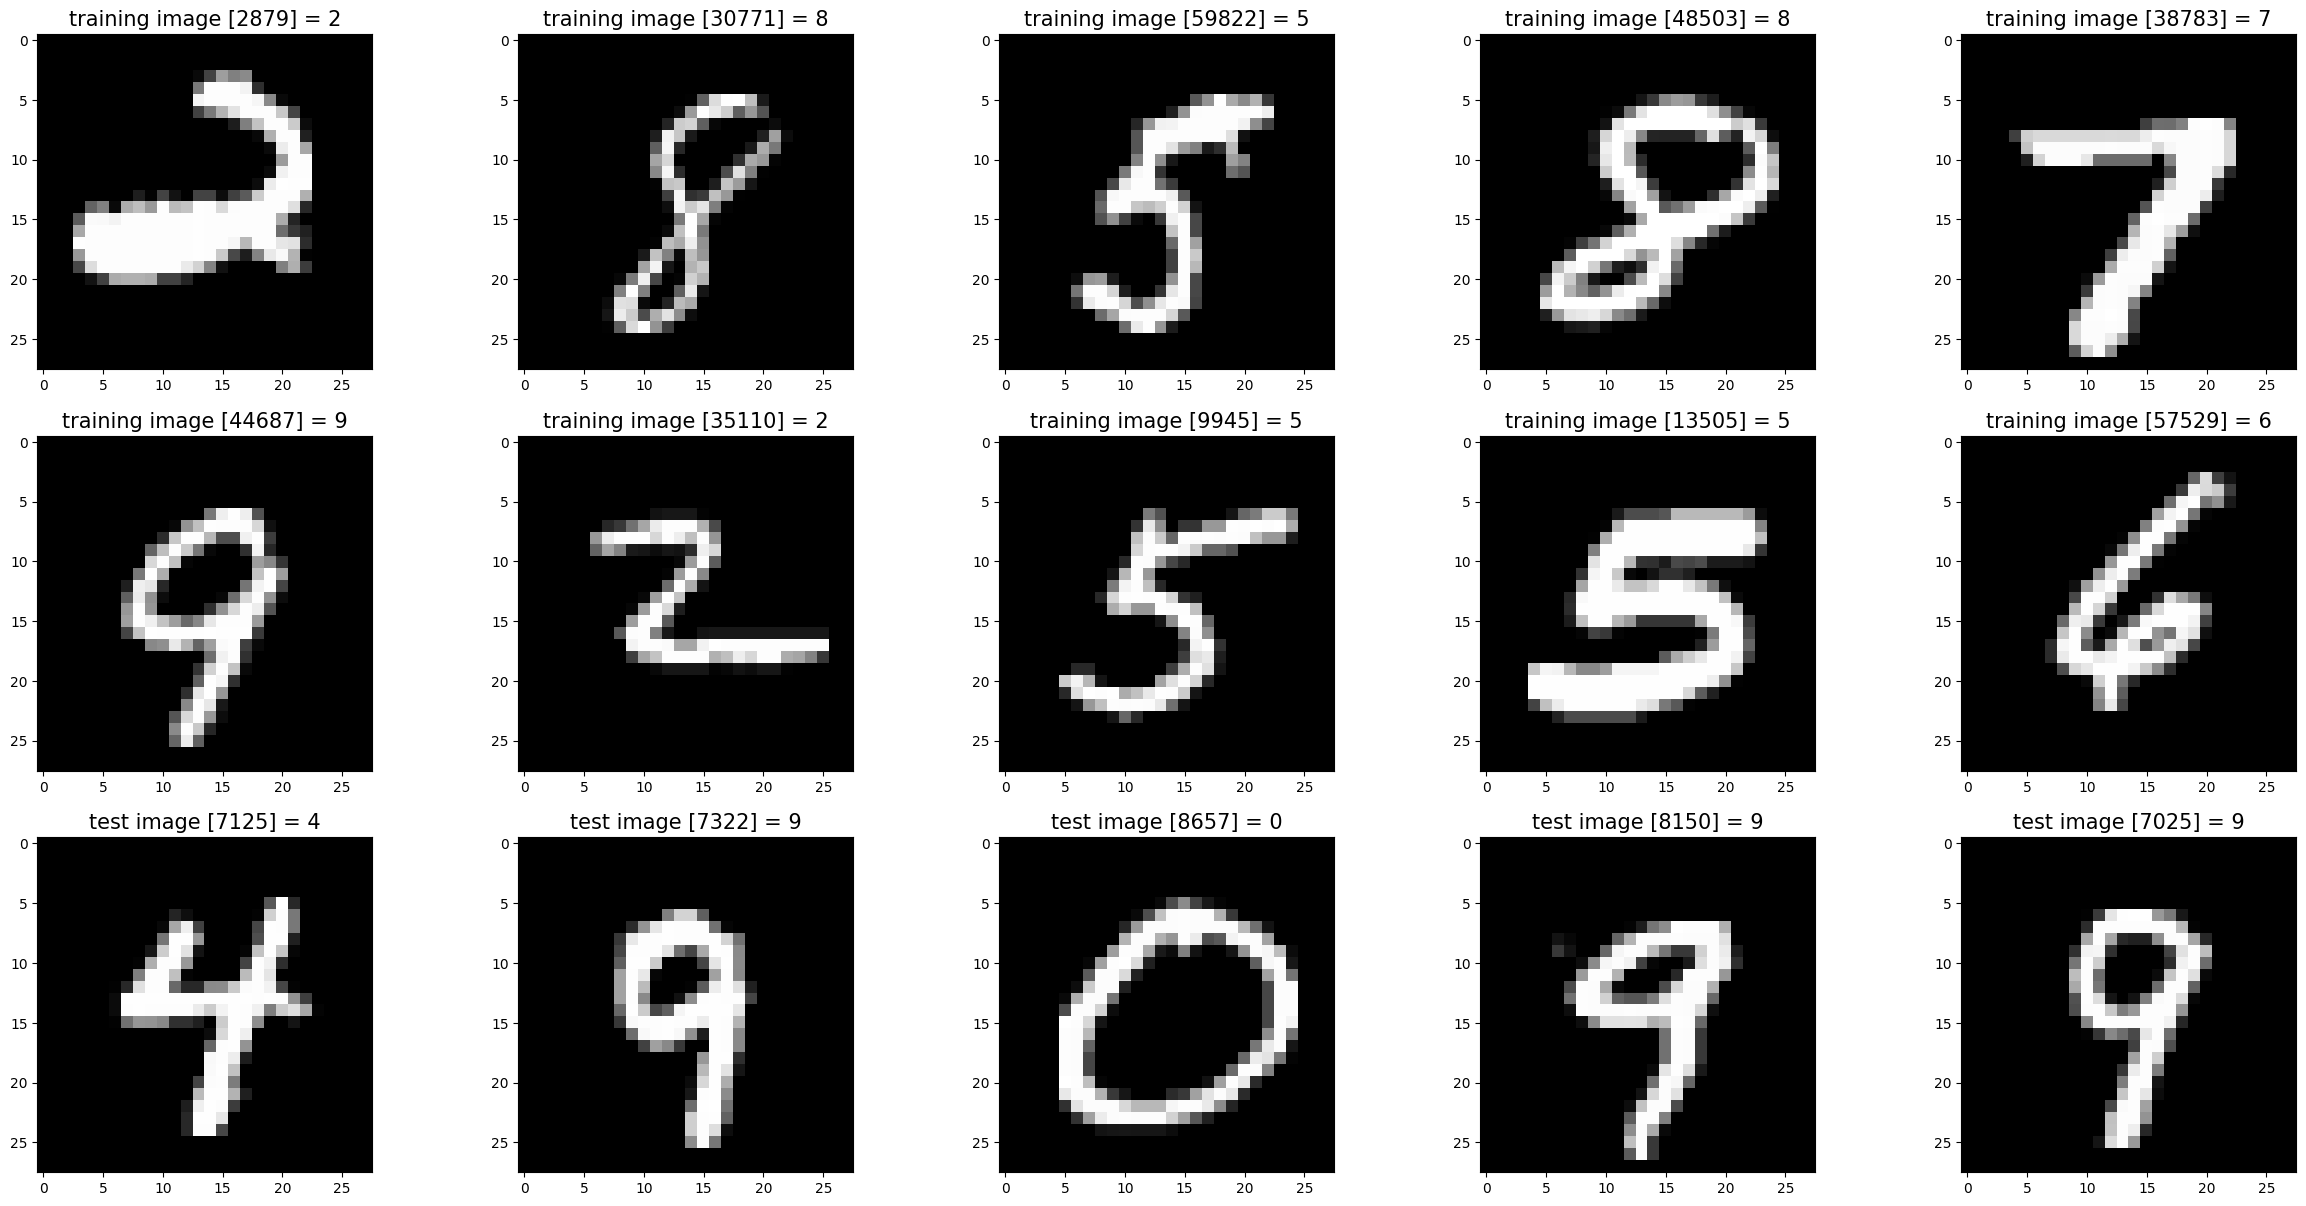

In [2]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = './datasets/MNIST_dataset'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts, savepath=None):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1
    
    if savepath:
        plt.savefig(savepath)
        plt.close()
    

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train_list, y_train_list), (x_test_list, y_test_list) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train_list[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train_list[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test_list[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test_list[r]))    

show_images(images_2_show, titles_2_show)

In [8]:
# Now we're going to create a factory method for CNNs
from abc import ABC, abstractmethod

class Layer(ABC):
    # defines the common behaviours all linear layers must have
    def __init__(self, input_shape, output_shape):
        # initialise weights and biases for single layer
        self.w = np.random.randn(input_shape, output_shape) # each hidden neuron has n weights (equal to number of hidden neurons in prev layer)
        self.b = np.random.randn(output_shape, 1)

    def forward(self, input):
        pass

    def backward(self, gradient):
        pass

    def update(self):
        pass

class SimpleLinearLayer(Layer):
    def __init__(self, input_shape, output_shape):
        #super().__init__(input_shape, output_shape)
        # He initialization for weights, zeros for biases
        self.w = np.random.randn(input_shape, output_shape) * np.sqrt(2. / input_shape)
        self.b = np.zeros((output_shape, 1))

    def forward(self, input):
        self.input = input
        self.z = np.dot(self.w.T, self.input) + self.b
        return self.z
    
    def backward(self, gradient):
        self.dw = np.dot(self.input, gradient.T)
        self.db = np.sum(gradient, axis=1, keepdims=True)
        dinput = np.dot(self.w, gradient)
        return dinput

    def update(self, learning_rate):
        batch_size = self.input.shape[1]
        self.w -= learning_rate * self.dw / batch_size
        self.b -= learning_rate * self.db / batch_size

class ReluLayer(Layer):
    def __init__(self, input_dims, output_dims):
        # this inherits the __init__ method from the abstract class, which initialises the weights and biases.
        super().__init__(input_dims, output_dims)
        # reinitialise weights to account for He initialisation
        self.w = np.random.randn(input_dims, output_dims) * np.sqrt(2 / input_dims)

    def forward(self, input):
        self.input = input 
        self.a = np.dot(self.w.T, self.input) + self.b
        z = np.maximum(0, self.a) # ReLU
        return z

    def backward(self, gradient):
        da = gradient * (self.a > 0)
        self.dw = np.dot(self.input, da.T) # dw has dims (input_dims, output_dims), da has dims (output_dims, batch_size), input has dims (input_dims, batch_size)
        self.db = np.sum(da * 1, axis=1, keepdims=True)
        dinput = np.dot(self.w, da)
        return dinput

    def update(self, learning_rate):
        batch_size = self.input.shape[1]
        self.w -= learning_rate * self.dw / batch_size
        self.b -= learning_rate * self.db / batch_size


# This is a more appropriate activation layer for use between convolutional layers.
# It applies the ReLU function element-wise and does not change the input shape.
class ReluActivation(Layer):
    def __init__(self):
        # This layer has no parameters to learn, so we don't need to initialize weights/biases.
        pass

    def forward(self, input_tensor):
        self.input_tensor = input_tensor
        return np.maximum(0, input_tensor)

    def backward(self, gradient):
        # The derivative of ReLU is 1 for positive inputs and 0 otherwise.
        d_relu = (self.input_tensor > 0) * 1
        return gradient * d_relu

    def update(self, **kwargs):
        # No weights or biases to update
        pass

class SoftmaxActivation(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        stable_input = input - np.max(input, axis=0, keepdims=True)
        exps =  np.exp(stable_input)
        self.output = exps / np.sum(exps, axis=0, keepdims=True)
        return self.output
    
    def backward(self, gradient):
        # gradient is dependent on all other inputs, so we must compute the Jacobian
        inner_product = np.sum(gradient * self.output, axis=0, keepdims=True)
        dinput = self.output * (gradient - inner_product)
        return dinput

    def update(self, **kwargs):
        pass


class FlattenLayer(Layer):
    # necessary to connect ConvLayer directly to SimpleLinearLayer
    def __init__(self, input_shape):
        # imput shape for a single sample (C, H, W)
        self.input_shape = input_shape
        self.output_shape = np.prod(input_shape)

    def forward(self, input_tensor):
        # input_tensor has shape (N, C, H, W)
        self.original_shape = input_tensor.shape
        batch_size = self.original_shape[0]
        return input_tensor.flatten().reshape(batch_size, -1).T

    def backward(self, gradient):
        return gradient.T.reshape(self.original_shape)

    def update(self, **kwargs):
        pass


class ConvLayer(Layer):
    # Convolutional layer
    def __init__(self, input_shape, kernel_size, out_channels):
        in_channels, in_height, in_width = input_shape # channels refers to number of channels
        self.out_channels = out_channels # how many kernels we want (analogous to n_neurons in layer), which defines the output
        self.input_shape = input_shape
        self.kernel_size = kernel_size
        self.output_shape = (out_channels,
                             in_height - kernel_size + 1,
                             in_width - kernel_size + 1)

        # He initialization for kernels, zeros for biases
        fan_in = in_channels * kernel_size * kernel_size
        std = np.sqrt(2. / fan_in)
        self.kernels = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * std
        self.biases = np.zeros(self.output_shape)

    def forward(self, input_batch):
        # input batch has shape (N, C, H, W)
        self.input_batch = input_batch
        batch_size = input_batch.shape[0]
        output_batch = np.zeros((batch_size, *self.output_shape))
        
        in_channels, in_height, in_width = self.input_shape
        out_channels, out_height, out_width = self.output_shape
        
        # convolution step
        # for each kernel sum over the input channels
        for n in range(batch_size):
            for k in range(out_channels): # iterate over n kernels
                for c in range(in_channels): # iterate over each channel
                    kern = self.kernels[k, c] # k'th kernel of c'th channels (ks, ks)
                    # perform the cross-correlation of kernel and sub-patch
                    for h in range(out_height):
                        for w in range(out_width):
                            #print(f"n:{n}, k:{k}, d:{d}, h:{h}, w:{w}")
                            patch = input_batch[n, c, h:h+self.kernel_size, w:w+self.kernel_size]
                            output_batch[n, k, h, w] += np.sum(patch * kern) # compute cross-correlation on each patch
                
            output_batch[n] += self.biases # add biases
        
        # output_batch has dims (samples, n_feature maps, output_height, output_width )
        self.output_batch = output_batch
        return output_batch

    def backward(self, gradient_batch):
        # gradient batch has shape (n, n_kernels, out_H, out_W)
        batch_size = gradient_batch.shape[0]

        
        self.dk = np.zeros_like(self.kernels) # same shape as (n_kernels, in_channels, ks, ks)
        dinput_batch = np.zeros_like(self.input_batch)      # same shape as (n, in_channels, H, W)
        self.db = np.sum(gradient_batch, axis=0) # biases are sum of the gradients flowing into neuron

        in_channels, in_height, in_width = self.input_shape
        out_channels, out_height, out_width = self.output_shape
        ks = self.kernel_size
        
        
        # gradient = dL / doutput
        # we want dL / dkernels and dL / dbiases
        # dL / dkernels = dL / doutput * doutput / dkernels
        # doutput / dkernels[k] = sum(input[d, h:h+self.kernel_size, w:w+self.kernel_size])
        # dinput is found by doing the reverse of cross-correlation
        # output = sum(input[] * kernel[]) thus, dloss / dinput = sum(kernel) * gradient

        # loop over each sample in batch
        for n in range(batch_size):
            # loop over each kernel (output channel)
            for k in range(out_channels):
                # loop over each input channel
                for c in range(in_channels):
                    # loop over each row in array
                    for h in range(out_height):
                        # loop over each column in array
                        for w in range(out_width):
                            g = gradient_batch[n, k, h, w]
                            patch = self.input_batch[n, c, h:h+ks, w:w+ks]
                            
                            # accumulate kernel gradient
                            self.dk[k, c] += g * patch

                            # propagate gradient into the input
                            dinput_batch[n, c, h:h+ks, w:w+ks] += g * self.kernels[k, c]

        return dinput_batch

    def update(self, learning_rate):
        batch_size = self.input_batch.shape[0]
        self.kernels -= learning_rate * self.dk / batch_size
        self.biases -= learning_rate * self.db / batch_size

class MaxPoolLayer(Layer):
    # comes after a conv layer to reduce the size of the feature map
    def __init__(self, input_shape, pool_size, stride):
        self.input_shape = input_shape
        self.pool_size = pool_size
        self.stride = stride
        in_channels, input_height, input_width = input_shape
        
        out_height = (input_height - pool_size) // stride + 1
        out_width = (input_width - pool_size) // stride + 1
        self.output_shape = (in_channels, out_height, out_width)
        
    
    def forward(self, input_batch):
        # input batch is (samples, n_feature_maps, map_height, map_width)
        self.input_batch = input_batch
        self.batch_size, in_channels, in_height, in_width = input_batch.shape
        out_channels, out_h, out_w = self.output_shape
        output_batch = np.zeros((self.batch_size, *self.output_shape))
        pool_size = self.pool_size
        stride = self.stride

        # iterate over input_batch
        for n in range(self.batch_size):
            # iterate over each feature map:
            for c in range(out_channels):
                for h in range(out_h):
                    for w in range(out_w):
                        h_start = h * stride
                        w_start = w * stride
                        h_end = h_start + pool_size
                        w_end = w_start + pool_size
                        
                        patch = input_batch[n, c, h_start:h_end, w_start:w_end]
                        output_batch[n, c, h, w] = np.max(patch)
        
        self.output_batch = output_batch
        return self.output_batch
    
    def backward(self, gradient_batch):
        dinput_batch = np.zeros_like(self.input_batch)
        batch_size, out_channels, out_height, out_width = gradient_batch.shape
        pool_size = self.pool_size
        stride = self.stride

        # iterate through batch samples
        for n in range(batch_size):
            # iterate through channels
            for c in range(out_channels):
                # pass a sliding window over each map in channel
                for h in range(out_height):
                    for w in range(out_width):
                        # define patch boundaries
                        h_start = h * stride
                        w_start = w * stride
                        h_end = h_start + pool_size
                        w_end = w_start + pool_size
                        
                        # get patch from original input map
                        patch = self.input_batch[n, c, h_start:h_end, w_start:w_end]
                        
                        # find the maximum of the patch and apply the corresponding gradient.
                        # it will be easier if we apply a mask of 1s and 0s with 1 corresponding to max.
                        max_patch = np.max(patch)
                        patch_mask = (patch == max_patch)

                        # remember that each patch in input_batch corresponds to a single gradient in gradient_batch
                        # we use += because the gradients are applied over a sliding window, so there are multiple sources
                        dinput_batch[n, c, h_start:h_end, w_start:w_end] += gradient_batch[n, c, h, w] * patch_mask

        return dinput_batch


    def update(self, **kwargs):
        pass



In [9]:
class LayerFactory(ABC):
    # responsibility is to declare the factory method

    @abstractmethod
    def create_layer(input_shape, output_shape):
        pass
    
class SimpleLayerFactory(LayerFactory):
    def create_layer(self, input_shape, output_shape):
        return SimpleLinearLayer(input_shape, output_shape)
    
class ReluLayerFactory(LayerFactory):
    def create_layer(self, input_shape, output_shape):
        return ReluLayer(input_shape, output_shape)

class ReluActivationFactory(LayerFactory):
    def create_layer(self):
        return ReluActivation()
    
class ConvLayerFactory(LayerFactory):
    def create_layer(self, input_shape, kernel_size, out_channels):
        return ConvLayer(input_shape, kernel_size, out_channels)
    
class MaxPoolLayerFactory(LayerFactory):
    def create_layer(self, input_shape, pool_size, stride):
        return MaxPoolLayer(input_shape, pool_size, stride)
    
class SoftmaxActivationFactory(LayerFactory):
    def create_layer(self, input_shape, output_shape):
        return SoftmaxActivation(input_shape, output_shape)
    
class FlattenLayerFactory(LayerFactory):
    def create_layer(self, input_shape):
        return FlattenLayer(input_shape)


class SequentialNetwork:
    def __init__(self):
        self.layers = []
    
    def add_layer(self, layer):
        self.layers.append(layer)
    
    def forward(self, input_data):
        # for loop through each layer in self.layers
        for layer in self.layers:
            input_data = layer.forward(input_data)
        
        y_predicted = input_data
        return y_predicted
    
    def backward(self, gradient):
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)

    def update(self, learning_rate):
        for layer in self.layers:
            layer.update(learning_rate=learning_rate)


class CCELoss:
    # categorical cross-entropy loss
    def calculate(self, y_predicted, y_true):
        # y_true is one hot encoded
        eps = 1e-9
        loss = -np.mean(y_true * np.log(y_predicted + eps))
        print(f"pred:{np.argmax(y_predicted, axis=0)}")
        print(f"true:{np.argmax(y_true, axis=0)}\n")
        return loss 

    def derivative(self, y_predicted, y_true):
        eps = 1e-9
        gradient = -y_true/(y_predicted+eps)
        return gradient

In [10]:
# x_train, y_train, x_test, y_test are the datasets we will be working with
# print(x_train[0])
# they are by default lists and must be converted into arrays first.
x_train = np.array(x_train_list)
x_test = np.array(x_test_list)
print(f"images have shape: {x_train.shape}") # (60000, 28, 28) -> 60,000 images, each are 28x28 single channel (1-255) arrays.

# before passing the arrays into the network, we must reshape the 2-D pixel array to be a 1-D vector.
# x_train = x_train.reshape(len(x_train), -1)
# x_test = x_test.reshape(len(x_test), -1)
# print(f"arr has shape: {x_train.shape}")
x_train = x_train / 255.0
x_test = x_test / 255.0 # convert pixel values between 0 and 1


y_train = np.zeros((len(y_train_list), len(np.unique(y_train_list))))
y_test = np.zeros((len(y_test_list), len(np.unique(y_test_list))))
# # one-hot-encode the labels 
for i, val in enumerate(y_train_list):
    y_train[i, val] = 1

for i, val in enumerate(y_test_list):
    y_test[i, val] = 1


images have shape: (60000, 28, 28)


In [11]:
# build training loop
# hyperparams
n_epochs = 5
learning_rate = 1e-3
batch_size = 64

# Create a two layer network with ReLU activation, MSE loss, and stochastic gradient descent
conv_layer = ConvLayerFactory()
linear_layer = SimpleLayerFactory()
relu_activation = ReluActivationFactory()
max_pool_layer = MaxPoolLayerFactory()
softmax_activation = SoftmaxActivationFactory()
flatten_layer = FlattenLayerFactory()

# Block 1
layer1 = conv_layer.create_layer(input_shape=(1, *x_train.shape[1:]), kernel_size=3, out_channels=20)
relu_act1 = relu_activation.create_layer()
pool1 = max_pool_layer.create_layer(input_shape=layer1.output_shape, pool_size=2, stride=2)

# Block 2
layer2 = conv_layer.create_layer(input_shape=pool1.output_shape, kernel_size=3, out_channels=20)
relu_act2 = relu_activation.create_layer()
pool2 = max_pool_layer.create_layer(input_shape=layer2.output_shape, pool_size=2, stride=2)


# Block 3
layer3 = conv_layer.create_layer(input_shape=pool2.output_shape, kernel_size=3, out_channels=20)
relu_act3 = relu_activation.create_layer()
pool3 = max_pool_layer.create_layer(input_shape=layer3.output_shape, pool_size=2, stride=2)


# Classifier
layer4 = flatten_layer.create_layer(input_shape=pool3.output_shape)
layer5 = linear_layer.create_layer(input_shape=layer4.output_shape, output_shape=y_train.shape[1])
layer6 = softmax_activation.create_layer(input_shape=y_train.shape[1], output_shape=y_train.shape[1])


neural_net = SequentialNetwork()
neural_net.add_layer(layer1)
neural_net.add_layer(relu_act1)
neural_net.add_layer(pool1)

neural_net.add_layer(layer2)
neural_net.add_layer(relu_act2)
neural_net.add_layer(pool2)

neural_net.add_layer(layer3)
neural_net.add_layer(relu_act3)
neural_net.add_layer(pool3)

neural_net.add_layer(layer4)
neural_net.add_layer(layer5)
neural_net.add_layer(layer6)
loss_fn = CCELoss()

# pre-allocate loss histories
train_loss_history = []
val_loss_history = []
accuracy_history = []

# Training loop
for epoch in range(n_epochs):
    
    total_train_loss = 0
    n_train_samples = 0
    
    # shuffle X_train and y_true in same way
    perm = np.random.permutation(len(x_train))
    x_train = x_train[perm]
    y_train = y_train[perm]
    
    # Separate data into batches
    for i in range(len(x_train) // batch_size):
        start, end = i * batch_size, (i+1) * batch_size
        x_batch = x_train[start:end].reshape(batch_size, 1, 28, 28)
        y_batch = y_train[start:end].T
        
        # forward pass
        y_pred_batch = neural_net.forward(x_batch)

        # calculate loss
        batch_loss = loss_fn.calculate(y_predicted=y_pred_batch, y_true=y_batch)
        gradient = loss_fn.derivative(y_predicted=y_pred_batch, y_true=y_batch)

        # accumulate training loss (corrected for uneven batch sizes)
        total_train_loss += batch_loss * x_batch.shape[0]
        n_train_samples += x_batch.shape[0]

        # backward pass
        neural_net.backward(gradient)

        # update
        neural_net.update(learning_rate=learning_rate)
        print(f"Batch {i}/{len(x_train)// batch_size} complete | Batch loss: {batch_loss:.4f}")
        

    mean_train_loss = total_train_loss / n_train_samples


    # validation loss and % accuracy
    total_val_loss = 0
    n_val_samples = 0
    total_correct_preds = 0

    for i in range(len(x_test) // batch_size):
        start, end = i * batch_size, (i+1) * batch_size
        val_x_batch = x_test[start:end].reshape(batch_size, 1, 28, 28)
        val_y_batch = y_test[start:end].T
        val_y_pred_batch = neural_net.forward(val_x_batch)
        val_batch_loss = loss_fn.calculate(y_predicted=val_y_pred_batch, y_true=val_y_batch)
        total_val_loss += val_batch_loss * val_x_batch.shape[0]
        n_val_samples += val_x_batch.shape[0]

        # accuracy
        # Get predicted class indices by finding the max logit along the class axis (axis=0)
        predicted_labels = np.argmax(val_y_pred_batch, axis=0)
        # Get true class indices from the one-hot encoded labels
        true_labels = np.argmax(val_y_batch, axis=0)
        # Sum the number of correct predictions in this batch
        total_correct_preds += np.sum(predicted_labels == true_labels)

    mean_val_loss = total_val_loss / n_val_samples
    accuracy = total_correct_preds / n_val_samples

    train_loss_history.append([epoch, mean_train_loss])
    val_loss_history.append([epoch, mean_val_loss])
    accuracy_history.append([epoch, accuracy])
    print(f"Epoch {epoch}: Train Loss: {mean_train_loss:.4f} | Val Loss: {mean_val_loss:.4f} | Val Accuracy: {accuracy:.4f}")

    if epoch % 1 == 0:
        # test split
        y_pred = neural_net.forward(x_test[:15].reshape(15, 1, 28, 28))

        # convert batch back to list of images ()
        x_test_list = (x_test[:15, :] * 255)#.astype('unit8')
        x_test_list = x_test_list.tolist()

        images_2_show = []
        titles_2_show = []
        for i, img in enumerate(x_test_list):
            images_2_show.append(img)
            pred_label = np.argmax(y_pred[:, i])
            true_label = y_test_list[i]
            score_for_true_label = y_pred[true_label, i]
            titles_2_show.append(f"Prediction: {pred_label}, P(y = {true_label}) = {score_for_true_label:.2f}")

        show_images(images_2_show, titles_2_show, savepath=f"./mnist/figs/accuracy_{epoch:0>4}")

        fig, (ax1, ax2) = plt.subplots(2,1)
        epochs, acc = zip(*accuracy_history)
        ax1.plot(epochs, acc)
        ax1.set_ylim(0, 1)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        
        epochs, train_losses = zip(*train_loss_history)
        ax2.plot(epochs, train_losses, '-', color='green', label='train')
        epochs, val_losses = zip(*val_loss_history)
        ax2.plot(epochs, val_losses, '-', color='red', label='validation')
        ax2.set_ylim(1e-5, 1)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('CCE Loss')
        ax2.set_yscale("log")
        ax2.legend()
        plt.tight_layout()
        fig.savefig(f"./mnist/figs/loss_{epoch:0>4}")
        plt.close()


pred:[4 4 4 1 4 8 8 1 1 4 1 1 1 4 4 1 4 1 8 4 4 1 8 4 1 4 4 1 8 1 1 1 4 1 4 4 1
 4 4 4 4 1 8 4 4 4 1 8 1 4 4 4 1 4 8 4 4 4 4 1 1 1 8 8]
true:[7 3 7 6 7 1 3 4 9 4 6 5 8 2 8 6 6 9 1 8 5 6 7 8 9 8 4 5 1 9 4 8 7 6 5 3 7
 9 0 7 3 0 8 9 7 2 5 9 9 9 0 1 4 0 1 8 9 2 3 6 4 6 3 1]

Batch 0/937 complete | Batch loss: 0.4138
pred:[4 4 4 8 4 1 4 4 4 4 8 1 8 8 4 4 4 8 8 1 8 1 1 8 8 8 1 8 4 1 4 8 8 4 4 1 4
 4 4 1 8 8 1 8 1 4 1 8 1 8 8 1 8 8 1 4 1 1 1 8 8 8 4 8]
true:[3 4 3 1 5 6 5 2 6 2 9 8 1 7 2 2 2 7 1 2 7 5 5 1 1 5 6 7 7 8 7 3 5 9 7 8 9
 6 5 6 5 5 0 7 5 4 6 8 6 0 1 6 7 9 6 0 4 4 8 3 7 3 2 3]

Batch 1/937 complete | Batch loss: 0.4215
pred:[8 4 8 8 8 1 8 8 1 1 1 8 4 4 1 8 4 4 8 8 8 1 4 1 1 4 4 4 4 4 8 8 8 1 4 4 4
 1 4 1 4 8 8 8 4 8 1 1 4 4 8 8 4 8 8 4 4 8 4 8 1 8 4 4]
true:[3 8 7 8 7 8 3 3 6 6 4 1 3 4 5 9 2 9 9 9 3 5 3 8 0 3 1 1 2 3 3 7 7 8 0 9 4
 5 4 4 9 3 3 9 3 5 5 9 6 2 8 2 9 8 1 0 5 2 6 9 5 8 1 8]

Batch 2/937 complete | Batch loss: 0.4246
pred:[4 4 8 1 8 1 4 4 1 1 4 4 1 8 1 8 4 4 1 4 8 1 4 8 8

KeyboardInterrupt: 